# Sentiment analysis

# Imports

In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

nltk.download("punkt")
nltk.download("stopwords")
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\baheu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\baheu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\baheu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
df = pd.read_csv('./data/data_JV_2020_2023_tokenised.csv')

In [3]:
df['title_y'] = df['title_y'].fillna('')
df2 = df[df['title_y'].str.contains('Cyberpunk')].copy()

In [4]:
df2.shape

(2746, 11)

# Data preprocessing

In [5]:
ps = PorterStemmer()

def stem_word(word):
    return ps.stem(word)

def stem_column(column):
    return column.apply(lambda x: ' '.join([stem_word(word) for word in nltk.word_tokenize(x)]))

def remove_stop_words(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words("english"))  
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [6]:
df2['text'] = df2['text'].fillna('')

In [7]:
df2["avis_stopwords"] = df2["text"].apply(remove_stop_words)
df2["avis_preprocess"] = stem_column(df2["avis_stopwords"])

# Modelisation (transfer learning)

In [8]:
MODEL_NAME = "LiYuan/amazon-review-sentiment-analysis"
TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME)
MODEL = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, from_tf = False)

sentiment_task = pipeline("sentiment-analysis", model=MODEL, tokenizer=TOKENIZER)

In [9]:
#df2 = df.iloc[:5000,:].copy()

In [10]:
def get_sentiment(text):
    
    max_length = 512
    text = text[:max_length]
    result = sentiment_task(text)[0]
    
    return result["label"]

df2['sentiment_HF'] =df2['text'].apply(get_sentiment)
# pour 5k lignes ca prend 13min donc pour 600k lignes ca prendra environ 7h

In [12]:
df2['sentiment_HF'] = df2['sentiment_HF'].apply(lambda x : x[0])
df2['sentiment_HF'] = df2['sentiment_HF'].astype('int')

# Evaluation performances

In [13]:
df2['rating']=df2['rating'].astype('int')

In [28]:
df2[['sentiment_HF','rating']]

,sentiment_HF,rating
0,5,4
712,5,5
713,5,5
742,1,1
769,1,1
...,...,...
621505,1,1
621757,5,5
621775,1,1
622481,5,5


In [15]:
df2['sentiment_pred'] = df2['sentiment_HF'].apply(lambda x : 1 if x == 1 else 1 if x == 2 else 2 if x == 3 else 3)
df2['sentiment_true'] = df2['rating'].apply(lambda x : 1 if x == 1 else 1 if x == 2 else 2 if x == 3 else 3)
df2['perf_count'] = df2.apply(lambda row: 1 if row['sentiment_pred'] == row['sentiment_true'] else 0, axis=1)


In [16]:
print(f"Performance : {round(df2['perf_count'].sum()/df2.shape[0]*100,2)}% de bonnes predictions")

Performance : 82.88% de bonnes predictions


# Récuperation des mots responsables des bons sentiments

In [25]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialiser l'analyseur de sentiments
sia = SentimentIntensityAnalyzer()

# Fonction pour extraire les mots les plus fréquents des commentaires positifs
def mots_positifs(commentaires):
    mots_positifs = []
    mots_a_exclure = ['br', 'game','great','like','playing','one','good','games','play','love','get','well','fun','really','would','time','works','use',
                      'nice','also','nice','even','much','playing','case','got','bought','loves']
    
    for commentaire in commentaires:
        if sia.polarity_scores(commentaire)['compound'] > 0:
            mots = [mot.lower() for mot in word_tokenize(commentaire) if mot.isalpha() and mot.lower() not in stopwords.words('english') and mot.lower() not in mots_a_exclure]
            mots_positifs.extend(mots)
            
    return mots_positifs

# Extraire les mots les plus fréquents dans les commentaires positifs
mots_freq_positifs = FreqDist(mots_positifs(df2[df2['sentiment_pred'] == 3]['text']))

In [26]:
print("Les mots les plus fréquents associés aux commentaires positifs :")
for mot, freq in mots_freq_positifs.most_common(200):
    print(f"{mot}: {freq}")

Les mots les plus fréquents associés aux commentaires positifs :
bugs: 254
story: 241
controller: 230
cyberpunk: 159
still: 157
glitches: 137
lot: 136
world: 130
pc: 129
hours: 125
amazing: 123
graphics: 119
better: 117
played: 116
issues: 116
far: 114
people: 112
xbox: 100
wait: 97
gameplay: 97
looks: 96
crashes: 94
think: 93
city: 91
make: 91
new: 91
pro: 90
first: 88
buy: 88
best: 87
many: 86
awesome: 83
experience: 83
feel: 83
see: 82
every: 80
characters: 79
look: 79
side: 79
sure: 77
pretty: 77
version: 77
worth: 76
give: 75
things: 73
way: 72
know: 72
bad: 72
say: 72
little: 72
patches: 71
times: 69
could: 69
day: 69
character: 68
want: 68
go: 67
open: 67
cdpr: 66
price: 65
feels: 65
since: 65
recommend: 65
ca: 63
back: 63
launch: 61
work: 61
right: 61
release: 60
patch: 60
base: 60
witcher: 60
around: 59
yes: 59
different: 59
overall: 58
actually: 57
update: 57
everything: 57
going: 57
able: 57
runs: 57
perfect: 56
enough: 56
design: 55
nothing: 55
comes: 55
buggy: 54
enjoy: 54

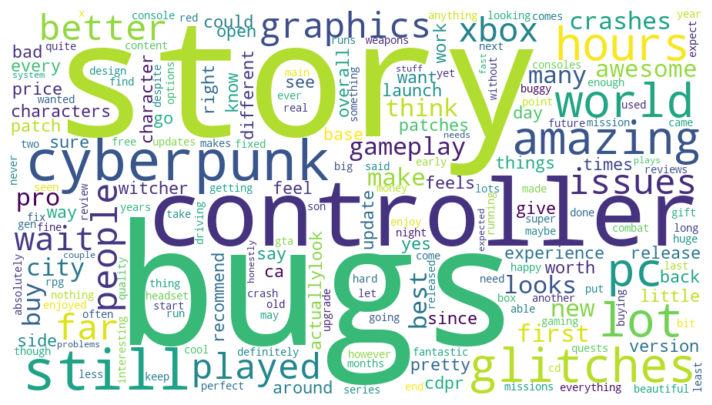

In [29]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Créer l'objet WordCloud
wordcloud = WordCloud(width=900, height=500, background_color='white').generate_from_frequencies(mots_freq_positifs)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Associer les mots positifs aux jeux correspondants